In [1]:
#Libraries to import
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import splitfolders

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
base_path = 'asl_dataset'

categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

filenames_list = []
categories_list = []


for category in categories:
    path = os.path.join(base_path, categories[category])
    filenames = os.listdir(path)
    for filename in filenames:
        filenames_list.append(os.path.join(categories[category],filename))
    #filenames_list = filenames_list+ filenames
    categories_list = categories_list + [category]*len(filenames)

df = pd.DataFrame({'filename': filenames_list, 'category': categories_list} )
df = df.sample(frac=1).reset_index(drop=True)

df

filename  category
0      k\hand2_k_left_seg_4_cropped.jpeg        20
1       s\hand5_s_dif_seg_1_cropped.jpeg        28
2       9\hand3_9_dif_seg_5_cropped.jpeg         9
3       q\hand5_q_bot_seg_4_cropped.jpeg        26
4       f\hand5_f_dif_seg_3_cropped.jpeg        15
...                                  ...       ...
2510  f\hand2_f_right_seg_2_cropped.jpeg        15
2511    d\hand2_d_bot_seg_3_cropped.jpeg        13
2512    3\hand1_3_top_seg_5_cropped.jpeg         3
2513    q\hand2_q_bot_seg_3_cropped.jpeg        26
2514    7\hand1_7_dif_seg_4_cropped.jpeg         7

[2515 rows x 2 columns]

In [10]:
path = os.path.join(base_path, df.filename[20])
img = plt.imread(path)
img.shape

(400, 400, 3)

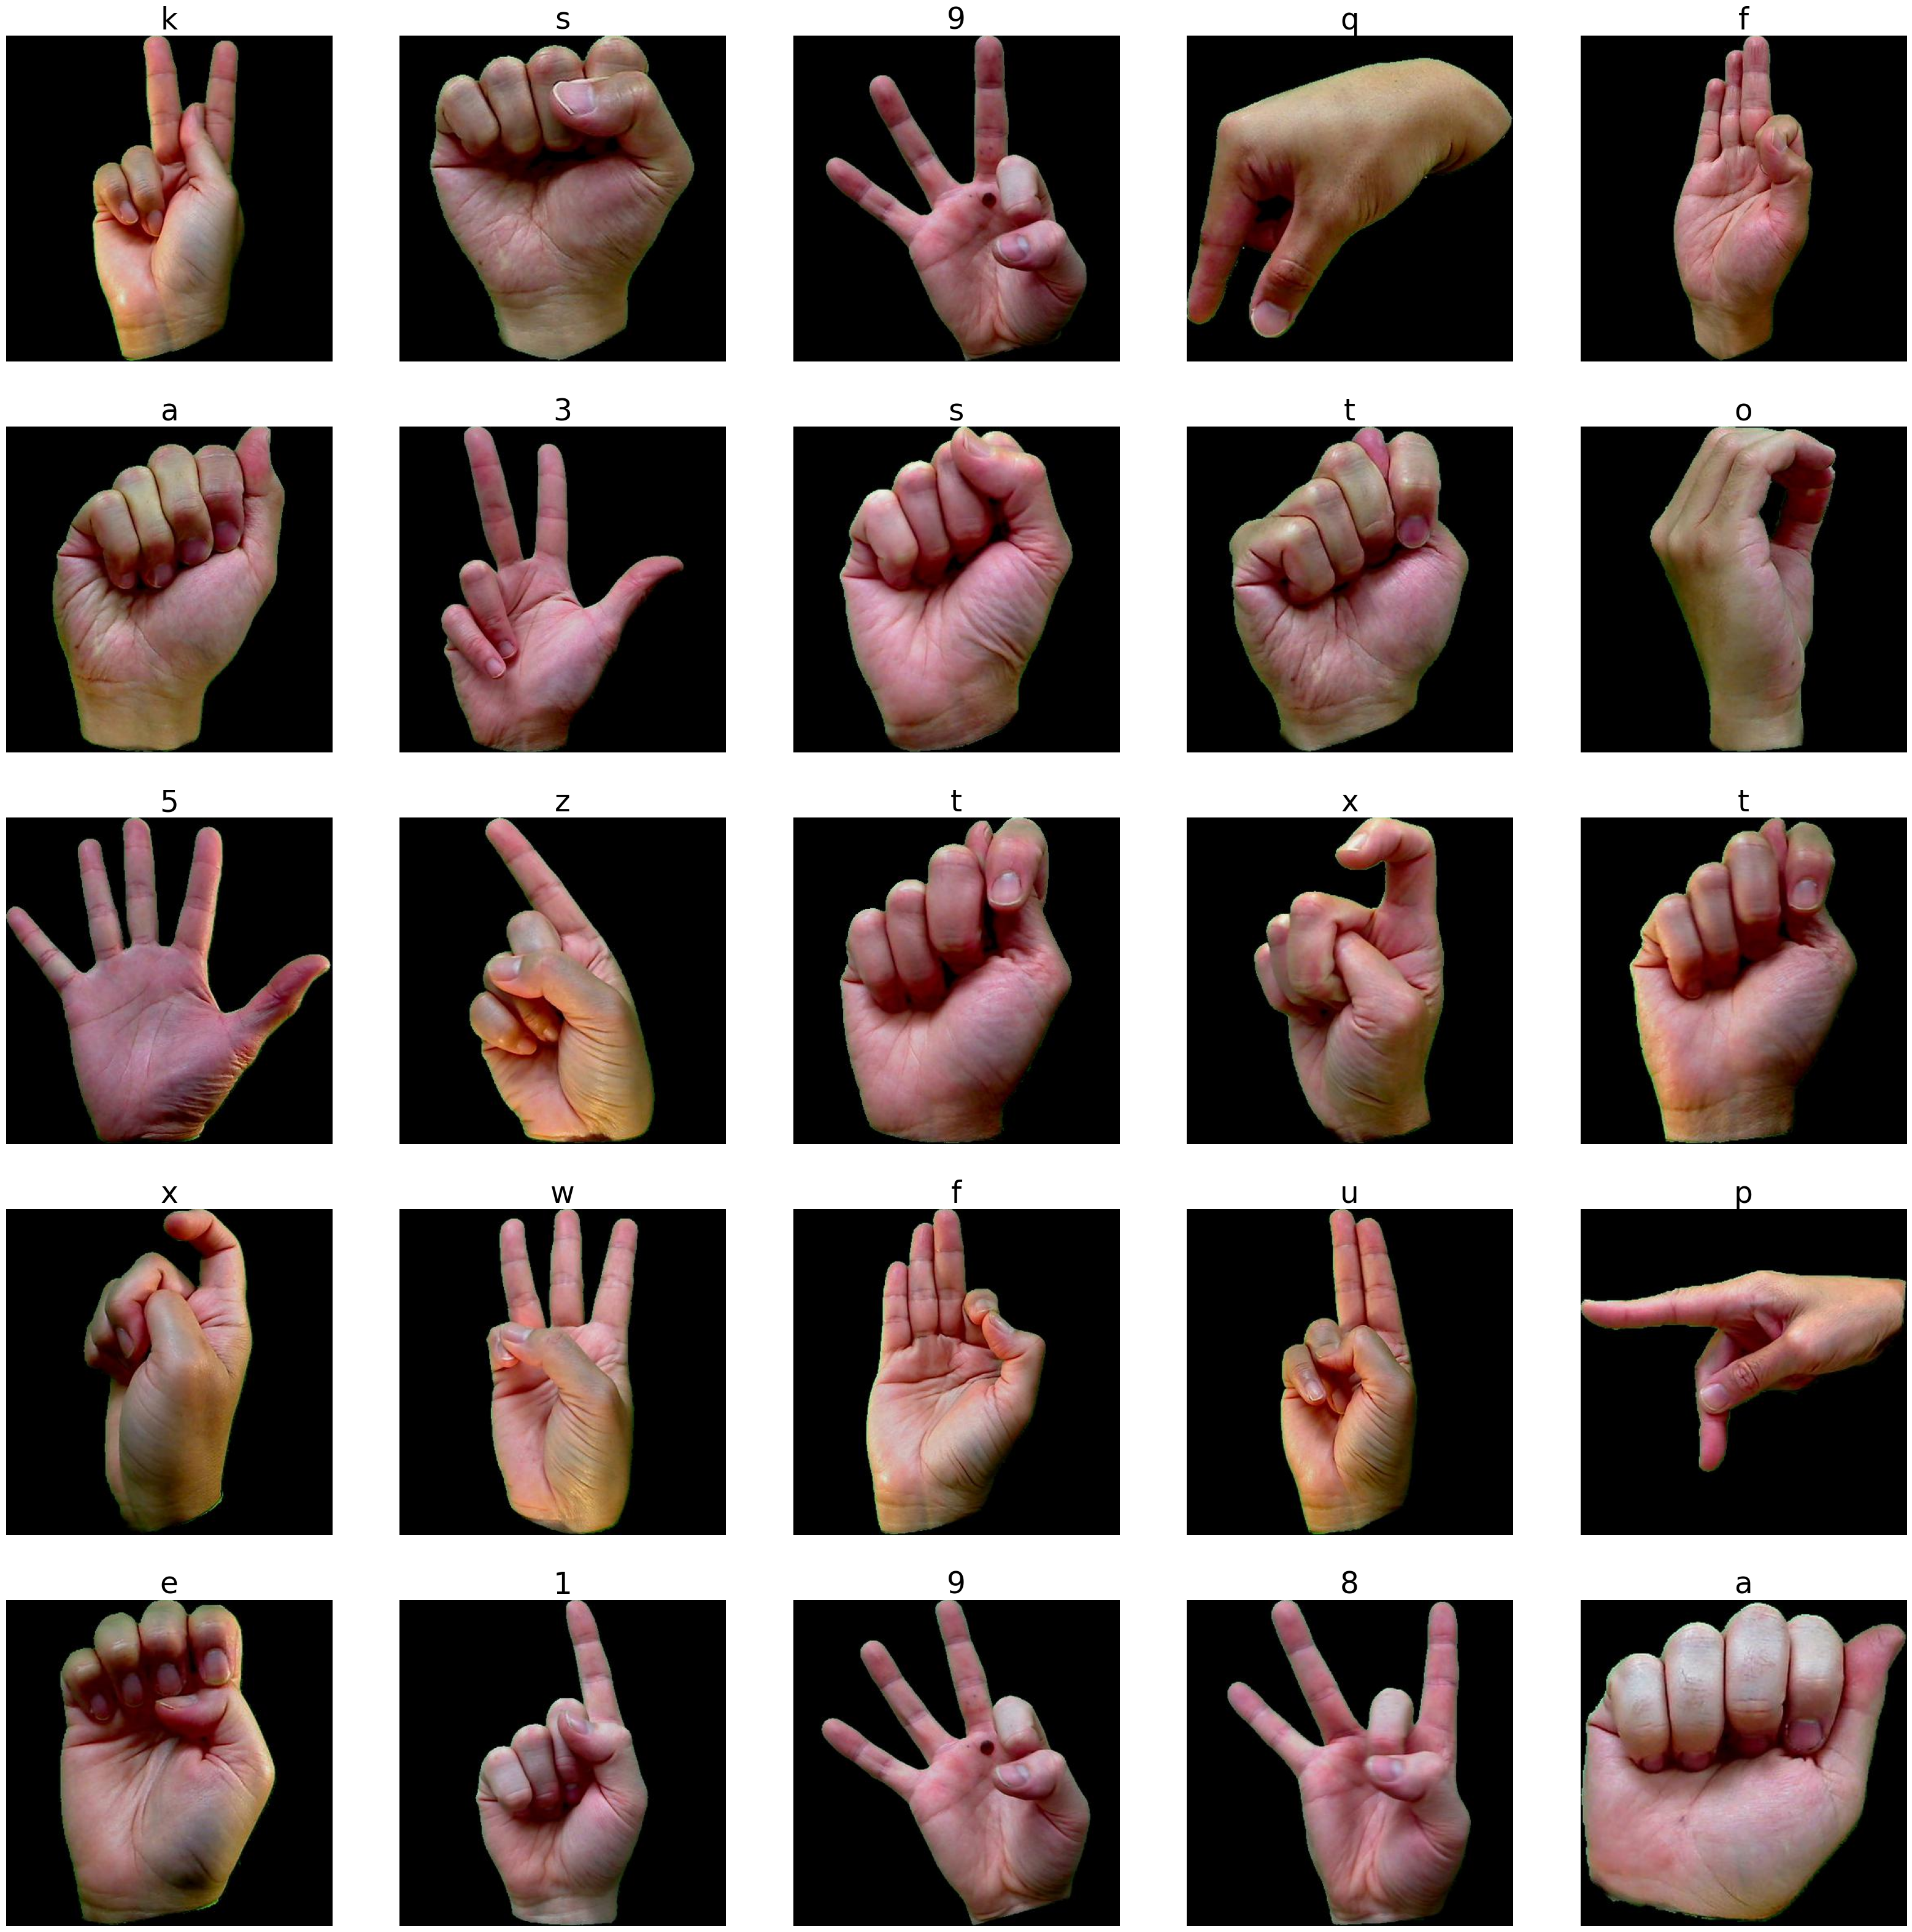

In [6]:
plt.figure(figsize=(40,40))

for i in range(25):
    path = os.path.join(base_path, df.filename[i])
    img = plt.imread(path)
    plt.subplot(5,5, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]],fontsize=35)
    plt.axis("off")

In [11]:
splitfolders.ratio('asl_dataset',output='asl_split', seed=1333, ratio=(0.8,0.1,0.1))

Copying files: 2515 files [00:24, 101.49 files/s]


In [12]:
datagen = ImageDataGenerator(rescale = 1.0/255)

In [14]:
train_path = 'asl_split/train'
test_path = 'asl_split/test'
val_path = 'asl_split/val'

batch_size = 32
image_size = 400
img_channel = 3
n_classes = 36

In [16]:
train_data = datagen.flow_from_directory(train_path,
                                         batch_size = batch_size,
                                         target_size=(image_size, image_size),
                                         class_mode= 'categorical')

test_data = datagen.flow_from_directory(test_path,
                                         batch_size = batch_size,
                                         target_size=(image_size, image_size),
                                         class_mode= 'categorical')

val_data = datagen.flow_from_directory(val_path,
                                         batch_size = batch_size,
                                         target_size=(image_size, image_size),
                                         class_mode= 'categorical')

Found 2012 images belonging to 36 classes.
Found 252 images belonging to 36 classes.
Found 251 images belonging to 36 classes.


In [25]:
inp = tf.keras.layers.Input(shape=(400,400,3))

model = tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu')(inp)
#model = tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.MaxPool2D(padding='same')(model)
model = tf.keras.layers.Dropout(0.2)(model)

#model = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.MaxPool2D(padding='same')(model)
model = tf.keras.layers.Dropout(0.3)(model)

#model = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.MaxPool2D(padding='same')(model)
model = tf.keras.layers.Dropout(0.4)(model)

model = tf.keras.layers.Flatten()(model)

#model = tf.keras.layers.Dense(512, activation='relu')(model)
model = tf.keras.layers.Dropout(0.2)(model)
model = tf.keras.layers.Dense(128, activation='relu')(model)
model = tf.keras.layers.Dropout(0.3)(model)

out = tf.keras.layers.Dense(n_classes, activation='softmax')(model)

model = tf.keras.Model(inputs = [inp], outputs = out)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 199, 199, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 99, 99, 64)        0         
 g2D)                                                      

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta= 0.001,
                                                  patience=5,
                                                  restore_best_weights=True,
                                                  verbose=0)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience = 2,
                                                            factor = 0.5,
                                                            verbose=0)

In [28]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [29]:
asl_class = model.fit(train_data,
                      validation_data= val_data,
                      epochs=20,
                      callbacks= [early_stopping, reduce_learning_rate],
                      verbose = 1)

Epoch 1/20


63/63 [==============================] - 202s 3s/step - loss: 2.9403 - accuracy: 0.3022 - val_loss: 1.2047 - val_accuracy: 0.7331 - lr: 0.0010
Epoch 2/20
63/63 [==============================] - 185s 3s/step - loss: 0.8955 - accuracy: 0.7406 - val_loss: 0.3260 - val_accuracy: 0.8964 - lr: 0.0010
Epoch 3/20
63/63 [==============================] - 185s 3s/step - loss: 0.3686 - accuracy: 0.8882 - val_loss: 0.2583 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 4/20
63/63 [==============================] - 185s 3s/step - loss: 0.2479 - accuracy: 0.9190 - val_loss: 0.1949 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 5/20
63/63 [==============================] - 184s 3s/step - loss: 0.1743 - accuracy: 0.9418 - val_loss: 0.1674 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 6/20
63/63 [==============================] - 185s 3s/step - loss: 0.1062 - accuracy: 0.9657 - val_loss: 0.2303 - val_accuracy: 0.9363 - lr: 0.0010
Epoch 7/20
63/63 [==============================] - 185s 3s/step - loss: 0

In [30]:
loss,acc = model.evaluate(train_data , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss,acc = model.evaluate(val_data, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 99.80119466781616
The Loss of the model for training data is: 0.01630454882979393
The accuracy of the model for validation data is: 94.02390718460083
The Loss of the model for validation data is: 0.16736401617527008


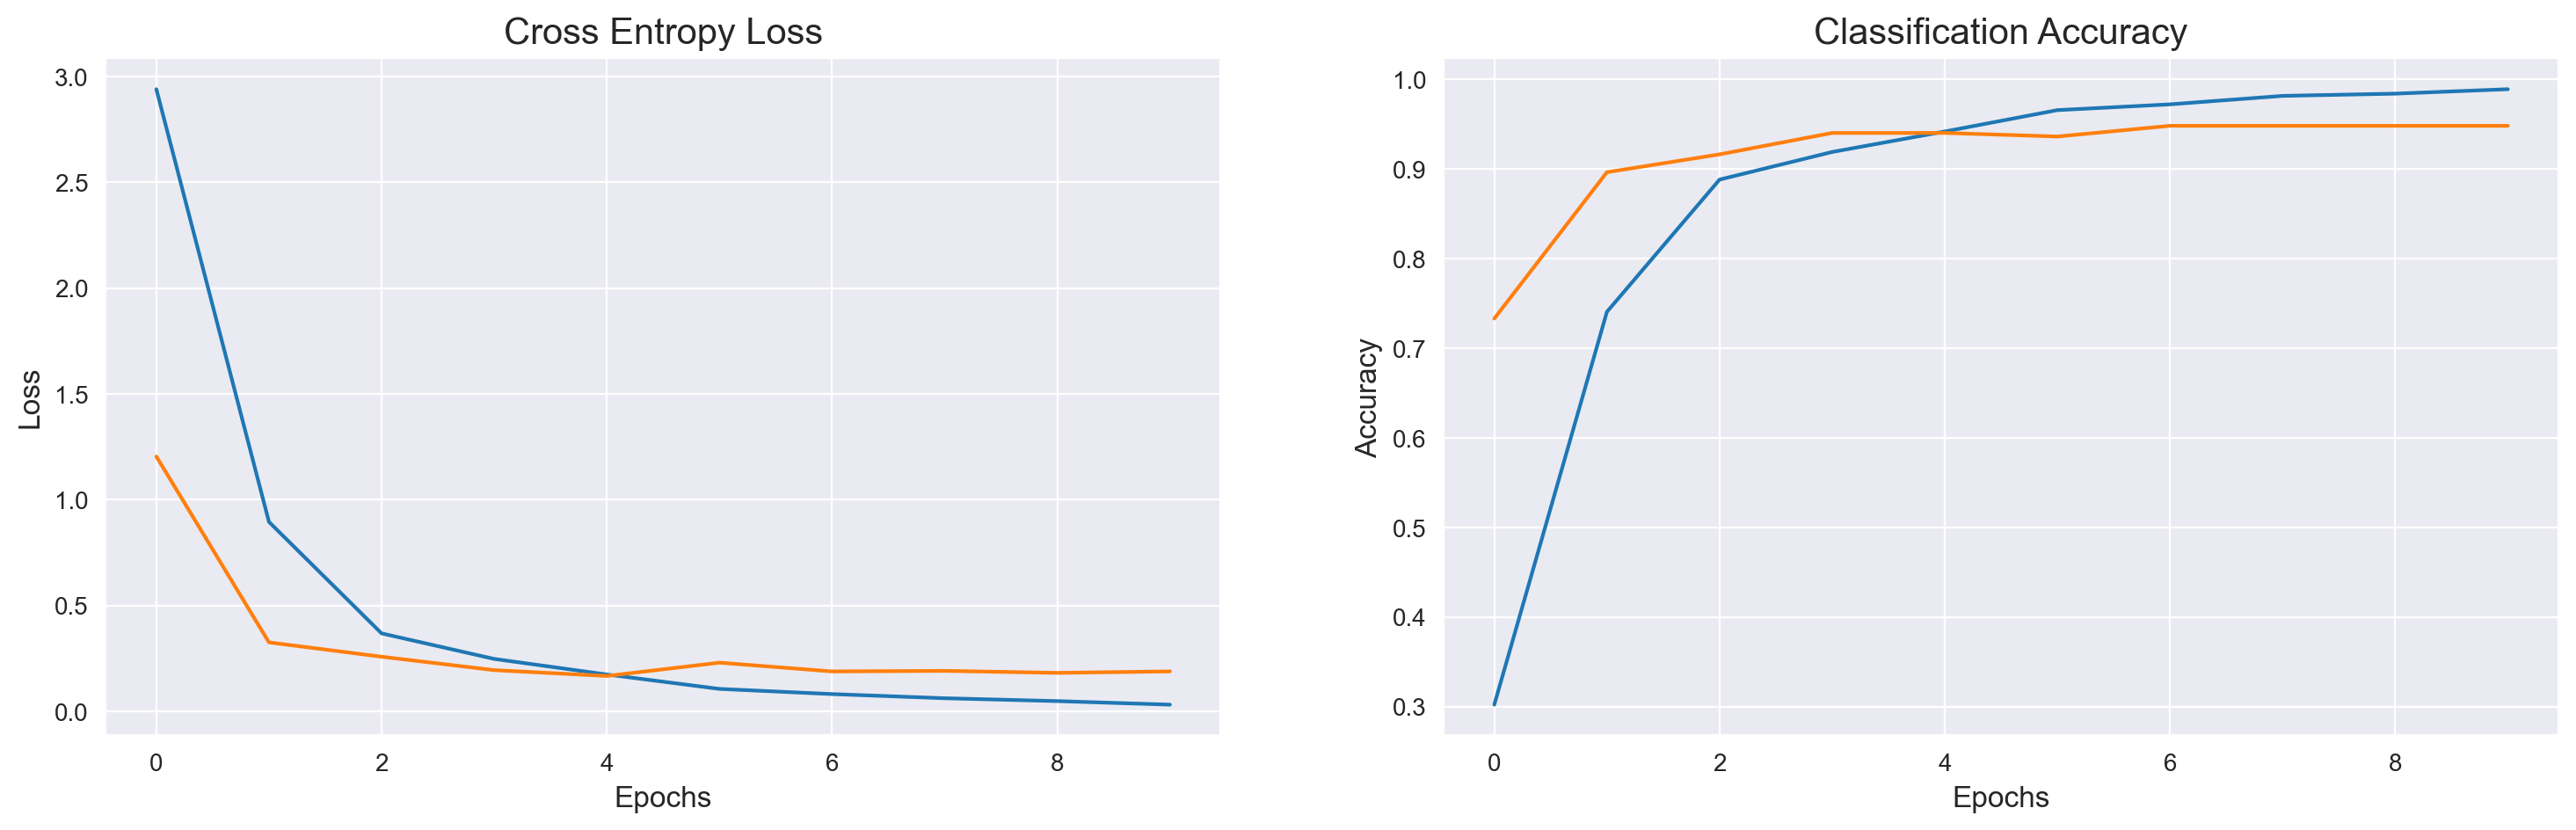

In [31]:
error = pd.DataFrame(asl_class.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [33]:
model.save('asl_model_2.h5')

d:\projects\Machine-Translation\myenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model

cnn = tf.keras.saving.load_model(
        'ASL_Model_1.h5', custom_objects=None, compile=True, safe_mode=True
    )



In [2]:
from cvzone.HandTrackingModule import HandDetector
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

cap = cv2.VideoCapture(0)
detector = HandDetector(maxHands=1)
safezone = 30

while True:
    success, img = cap.read()
    try:
        hands, img = detector.findHands(img)
        if hands:
            hand = hands[0]
            x,y,w,h = hand['bbox']
            imgcrop = img[y-safezone:y+h+safezone, x-safezone:x+w+safezone]
            
            imgcrop = cv2.cvtColor(imgcrop, cv2.COLOR_BGR2RGB)
            imgcrop = cv2.resize(imgcrop, (200,200))
            imgcrop = tf.keras.utils.img_to_array(imgcrop)
            imgcrop = imgcrop/255
            imgcrop = np.expand_dims(imgcrop, axis=0)
            prediction = cnn.predict(imgcrop)
            prediction = np.argmax(prediction, axis = 1)
            print(prediction)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(imgcrop, f"{prediction}", (0,100), font)
                   
    except:
        pass
    cv2.imshow('HandDetection', img)
    cv2.waitKey(1)

1/1 [==============================] - 0s 424ms/step
[19]
1/1 [==============================] - 0s 65ms/step
[23]
1/1 [==============================] - 0s 57ms/step
[26]
1/1 [==============================] - 0s 58ms/step
[23]
1/1 [==============================] - 0s 67ms/step
[26]
1/1 [==============================] - 0s 53ms/step
[26]
1/1 [==============================] - 0s 60ms/step
[23]
1/1 [==============================] - 0s 53ms/step
[26]
1/1 [==============================] - 0s 61ms/step
[23]
1/1 [==============================] - 0s 69ms/step
[23]
1/1 [==============================] - 0s 61ms/step
[23]
1/1 [==============================] - 0s 62ms/step
[23]
1/1 [==============================] - 0s 65ms/step
[23]
1/1 [==============================] - 0s 51ms/step
[23]
1/1 [==============================] - 0s 60ms/step
[23]
1/1 [==============================] - 0s 53ms/step
[23]
1/1 [==============================] - 0s 70ms/step
[23]
1/1 [=========================

In [3]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = r"F:\Onedrive\OneDrive - vitbhopal.ac.in\Pictures\Screenshots\Screenshot 2023-10-07 191331.png"
new_img = image.load_img(img_path, target_size=(200, 200))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
prediction = cnn.predict(img)
prediction = np.argmax(prediction,axis=1)
print(prediction)

1/1 [==============================] - 1s 1s/step
[23]


In [5]:
import cv2
import streamlit as st
import numpy as np

# Initialize the VideoCapture object
cap = cv2.VideoCapture(0)

# Function to read and display the video stream
def main():
    st.title("OpenCV VideoCapture in Streamlit")

    if not cap.isOpened():
        st.error("Error: Unable to access the camera.")
        return

    st.image([], use_column_width=True, channels="BGR")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Display the video frame in Streamlit
        st.image(frame, use_column_width=True, channels="BGR")

    # Release the video capture when the app is closed
    cap.release()

if __name__ == "__main__":
    main()

2023-10-07 10:16:44.677 
  command:

    streamlit run c:\Users\ASUS\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [4]:
s = "acb"
t = "ahcgdb"

def is_sunsequence(s,t):
    
    if len(s)>len(t): return False
    if len(s) == 0: return True
    sub = 1
    for i in range(0, len(t)-1):
        if sub <=len(s)-1:
            if s[sub] == t[i]:
                sub+=1
    return sub == len(s)
is_sunsequence(s,t)

False

In [4]:
import cv2
import numpy as np
from cvzone.HandTrackingModule import HandDetector

categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

def hand_capture(img):
    detector = HandDetector(maxHands=1)
    safezone = 120
    hands, img2 = detector.findHands(img)
    if hands:
        hand = hands[0]
        x,y,w,h = hand['bbox']
        imgcrop = img[y-safezone:y+h+safezone, x-safezone:x+w+safezone]
        return imgcrop , True
    else:
        return img , False
    
from tensorflow.keras.models import load_model
import tensorflow as tf


def load_model():
    model = tf.keras.saving.load_model(
        'asl_model_1.h5', custom_objects=None, compile=False, safe_mode=True
    )
    return model
model = load_model()    

cap = cv2.VideoCapture(0)
        
while cap.isOpened():
    ret, frame = cap.read()

    new_img , ishand = hand_capture(frame)
    if ishand:
        print(new_img)
        # img = tf.image.resize(new_img , (200 , 200))
        # img = tf.keras.preprocessing.image.img_to_array(img)
        # img = np.expand_dims(img, axis=0)
        # prediction = model.predict(img)
        # prediction = np.argmax(prediction,axis=1)
        # letter = categories[prediction[0]]
        # print(letter)
        #prediction = model.predict(crop_img)
    else :
        print("  ")
    cv2.imshow('frame' , frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
  
[[[108 102 109]
  [108 102 108]
  [107 101 106]
  ...
  [ 77  81  58]
  [ 75  80  57]
  [ 72  78  54]]

 [[106  99 108]
  [109 102 111]
  [109 103 110]
  ...
  [ 74  79  55]
  [ 76  81  58]
  [ 73  79  55]]

 [[106  97 107]
  [105  98 106]
  [109 103 108]
  ...
  [ 74  78  56]
  [ 75  79  58]
  [ 72  77  56]]

 ...

 [[114 102 105]
  [116 105 107]
  [117 105 106]
  ...
  [ 70  77  57]
  [ 72  76  58]
  [ 74  78  59]]

 [[114 102 105]
  [115 103 106]
  [117 105 106]
  ...
  [ 71  76  59]
  [ 72  76  60]
  [ 73  77  61]]

 [[115 103 107]
  [115 103 106]
  [115 104 105]
  ...
  [ 72  76  59]
  [ 71  75  58]
  [ 73  77  61]]]
[[[ 58  80 112]
  [ 57  76 108]
  [ 58  74 104]
  ...
  [ 60  68  53]
  [ 62  70  56]
  [ 62  70  56]]

 [[ 59  81 113]
  [ 57  78 108]


KeyboardInterrupt: 

: 